# CSC 620 - HW#2

By: Mark Kim

Notebook by:
[Kostas](https://www.kaggle.com/code/kstathou/word-embeddings-logistic-regression/notebook)

This notebook is a walkthrough of creating word embeddings with Word2Vec and
then using Logistic Regression to predict the cuisine of a recipe by its
ingredients.

## Imports & Data Setup

In [7]:
import os
import gensim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

print(os.listdir("./input"))
%matplotlib inline

['.DS_Store', 'test.json', 'train.json']


### Read in Data

In [4]:
data = pd.read_json('./input/train.json')
test = pd.read_json('./input/test.json')

In [5]:
print('Training data shape: {}'.format(data.shape))
print('Test data shape: {}'.format(test.shape))

Training data shape: (39774, 3)
Test data shape: (9944, 2)


In [6]:
# Target variable 
target = data.cuisine

Here we get the number of ingredients for each recipe.

In [8]:
data['ingredient_count'] = data.ingredients.apply(lambda x: len(x))

In [38]:
data['ingredients']

0        [romaine lettuce, black olives, grape tomatoes...
1        [plain flour, ground pepper, salt, tomatoes, g...
2        [eggs, pepper, salt, mayonaise, cooking oil, g...
3                      [water, vegetable oil, wheat, salt]
4        [black pepper, shallots, cornflour, cayenne pe...
                               ...                        
39769    [light brown sugar, granulated sugar, butter, ...
39770    [KRAFT Zesty Italian Dressing, purple onion, b...
39771    [eggs, citrus fruit, raisins, sourdough starte...
39772    [boneless chicken skinless thigh, minced garli...
39773    [green chile, jalapeno chilies, onions, ground...
Name: ingredients, Length: 39774, dtype: object

In [9]:
def flatten_lists(lst):
    """Remove nested lists."""
    return [item for sublist in lst for item in sublist]

### Visualize Data

The author chose to graph the number of recipes against the number of
ingredients for the first graph.  The second graph shows the most popular
ingredients and number of recipes they are contained in and finally the last
graph shows the average number of ingredients by cuisine.

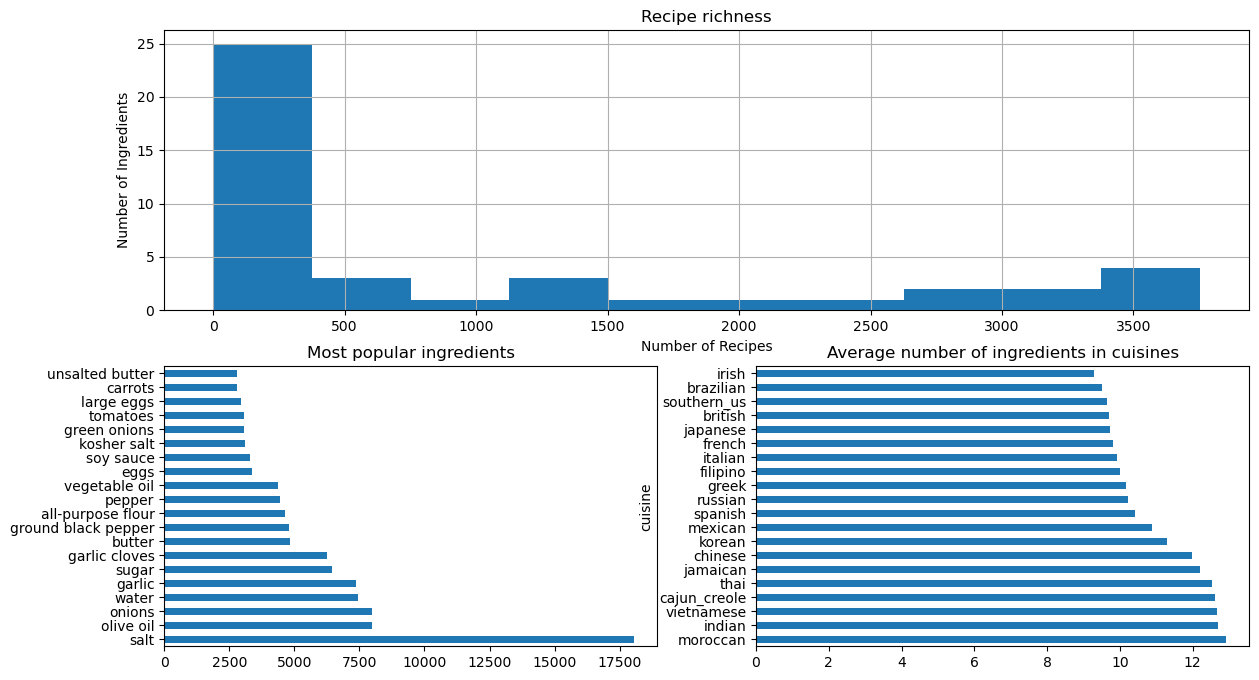

In [36]:
f = plt.figure(figsize=(14,8))
gs = gridspec.GridSpec(2, 2)

ax1 = plt.subplot(gs[0, :])
data.ingredient_count.value_counts().hist(ax=ax1)
ax1.set_title('Recipe richness', fontsize=12)
ax1.set_xlabel("Number of Recipes")
ax1.set_ylabel("Number of Ingredients")

ax2 = plt.subplot(gs[1, 0])
pd.Series(flatten_lists(list(data['ingredients']))).value_counts()[:20].plot(kind='barh', ax=ax2)
ax2.set_title('Most popular ingredients', fontsize=12)

ax3 = plt.subplot(gs[1, 1])
data.groupby('cuisine').mean()['ingredient_count'].sort_values(ascending=False).plot(kind='barh', ax=ax3)
ax3.set_title('Average number of ingredients in cuisines', fontsize=12)

plt.show()

## Using Gensim Word2Vec

### Initialize Model

Here the Word2Vec model is initialized with the ingredients from the training
set.

In [23]:
# Feed a word2vec with the ingredients
w2v = gensim.models.Word2Vec(list(data.ingredients), vector_size=350, window=10, min_count=2, epochs=20)

In [25]:
w2v.save("w2v.model")

In [ ]:
w2v = gensim.models.Word2Vec.load("w2v.model")

Once the words were added to the Word2Vec model, we can check the similarities
of words to the word vectors generated for the ingredients list.

In [26]:
w2v.wv.most_similar(['meat'])

[('beef', 0.6936466097831726),
 ('pork', 0.6321378946304321),
 ('pork chops', 0.6281569600105286),
 ('ground beef', 0.6092635989189148),
 ('chuck roast', 0.595958948135376),
 ('chicken', 0.590027391910553),
 ('beef brisket', 0.5811654329299927),
 ('pork loin', 0.5716992616653442),
 ('pork shoulder', 0.5578860640525818),
 ('broth', 0.5578328967094421)]

In [27]:
w2v.wv.most_similar(['chicken'])

[('chicken breasts', 0.7487109899520874),
 ('boneless chicken breast', 0.7229456305503845),
 ('chicken thighs', 0.7008324265480042),
 ('boneless skinless chicken breasts', 0.6878188848495483),
 ('chicken pieces', 0.6534408926963806),
 ('cooked chicken', 0.6506494283676147),
 ('boneless chicken skinless thigh', 0.6364151239395142),
 ('chicken legs', 0.6021285653114319),
 ('chicken meat', 0.5932704210281372),
 ('meat', 0.5900274515151978)]

### Remove Out-of-Vocabulary words and Average Recipe Ingredient Vectors

Here, the author creates a function that removes all out-of-vocabulary words
from each recipe, then averages the vectors of all the ingredients in each recipe.

In [61]:
def document_vector(doc):
    """Create document vectors by averaging word vectors. Remove out-of-vocabulary words."""
    doc = [word for word in doc if word in w2v.wv.index_to_key]
    return np.mean(w2v.wv[doc], axis=0)

Then the function is applied to both the training set and the test set.

In [62]:
data['doc_vector'] = data.ingredients.apply(document_vector)
test['doc_vector'] = test.ingredients.apply(document_vector)

### Normalize Labels

The cuisine labels are normalized to a sequence of integers starting from 0.
This simply itemizes the cuisines, removes duplicates, then maps each cuisine to
a natural number value.

In [63]:
lb = LabelEncoder()
y = lb.fit_transform(target)

### Recipe Vector List

Now, the training and test set recipe vectors are put into a list for training
and prediction/testing.

In [64]:
X = list(data['doc_vector'])
X_test = list(test['doc_vector'])

## Logistic Regression

A logistic regression model is initialized here.

In [69]:
clf = LogisticRegression(C=100)

The model is then trained with the training data (the recipe ingredient mean
vectors) and their corresponding cuisine labels.

In [70]:
clf.fit(X, y)

LogisticRegression(C=100)

### Predict the Cuisines from the Test Set

Finally, the classes (cuisines) are predicted from the test set.  Since the test
set is unlabeled, we do not know the effectiveness of the logistic regression.
We could create a test set from the training set to resolve this issue.

In [71]:
y_test = clf.predict(X_test)
y_pred = lb.inverse_transform(y_test)

In [72]:
test_id = [id_ for id_ in test.id]
sub = pd.DataFrame({'id': test_id, 'cuisine': y_pred}, columns=['id', 'cuisine'])
sub.to_csv('clf_output.csv', index=False)